In [1]:
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary

## Load training data and plot it

Note how the data is loaded with `train = True`. You can load the test data in a similar fashion, just set `train = False`. Feel free to reuse my plot function!

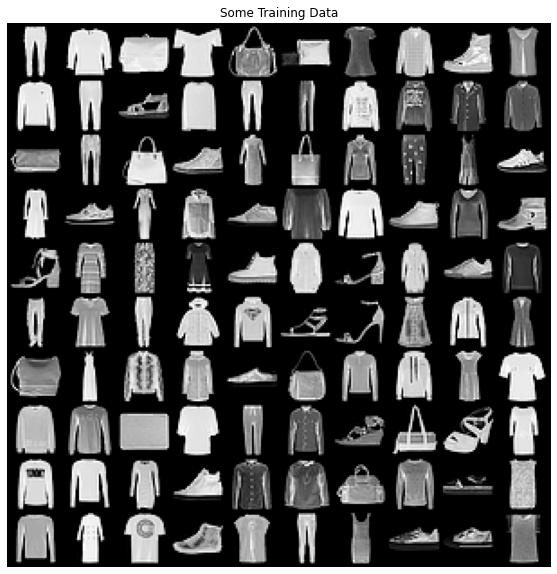

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 100
train_data = FashionMNIST("./data", train = True, download = True,
                          transform=transforms.ToTensor())
data_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

width = 28
height = 28
input_size = width * height

def plot_images(batch, rows, cols, title = ""):
    plt.figure(figsize = (rows, cols))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(
        vutils.make_grid(batch[:(rows * cols)], nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))

first_batch = next(iter(data_loader))
plot_images(first_batch[0], 10, 10, "Some Training Data")

### Define Models

In [4]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.elayer1 = nn.Linear(input_size, 256)
        self.ebatch1 = nn.BatchNorm1d(256)
        self.elayer2 = nn.Linear(256, 128)
        self.ebatch2 = nn.BatchNorm1d(128)
        self.elayer3 = nn.Linear(128, out_size)

        self.dlayer1 = nn.Linear(out_size, 128)
        self.dbatch1 = nn.BatchNorm1d(128)
        self.dlayer2 = nn.Linear(128, 256)
        self.dbatch2 = nn.BatchNorm1d(256)
        self.dlayer3 = nn.Linear(256, input_size)
    
    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.elayer1(x)))
        y2 = F.elu(self.ebatch2(self.elayer2(y1)))
        z = F.elu(self.elayer3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dlayer1(z)))
        y2 = F.elu(self.dbatch2(self.dlayer2(y1)))
        x = torch.sigmoid(self.dlayer3(y2))
        return x
        
    def forward(self, x):
        x = x.view(-1, input_size)
        z = self.encoder(x)
        y = self.decoder(z)
        y = y.view(-1, 1, width, height)
        return y

class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(ConvolutionalAutoencoder, self).__init__()
        self.econv1 = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
        self.ebatch1 = nn.BatchNorm2d(32)
        self.econv2 = nn.Conv2d(32, 8, kernel_size = 5, bias = False)
        self.ebatch2 = nn.BatchNorm2d(8)
        self.econv3 = nn.Conv2d(8, out_size, kernel_size = 20, bias = True)

        self.dconv1 = nn.ConvTranspose2d(out_size, 8, kernel_size = 20, bias = True)
        self.dbatch1 = nn.BatchNorm2d(8)
        self.dconv2 = nn.ConvTranspose2d(8, 32, kernel_size = 5, bias = False)
        self.dbatch2 = nn.BatchNorm2d(32)
        self.dconv3 = nn.ConvTranspose2d(32, 1, kernel_size = 5, bias = False)

    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.econv1(x)))
        y2 = F.elu(self.ebatch2(self.econv2(y1)))
        z = F.elu(self.econv3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dconv1(z)))
        y2 = F.elu(self.dbatch2(self.dconv2(y1)))
        x = torch.sigmoid(self.dconv3(y2))
        return x
     
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

### Problem 1: Loading Pre-Trained Weights and Instantiating Models

In [5]:
fc_model_16 = FullyConnectedAutoencoder(out_size=16)
fc_model_16.load_state_dict(torch.load('fcAE16.pth', map_location=torch.device('cpu')))
fc_model_16.eval()

fc_model_32 = FullyConnectedAutoencoder(out_size=32)
fc_model_32.load_state_dict(torch.load('fcAE32.pth', map_location=torch.device('cpu')))
fc_model_32.eval()

fc_model_128 = FullyConnectedAutoencoder(out_size=128)
fc_model_128.load_state_dict(torch.load('fcAE128.pth', map_location=torch.device('cpu')))
fc_model_128.eval()

FullyConnectedAutoencoder(
  (elayer1): Linear(in_features=784, out_features=256, bias=True)
  (ebatch1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elayer2): Linear(in_features=256, out_features=128, bias=True)
  (ebatch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elayer3): Linear(in_features=128, out_features=128, bias=True)
  (dlayer1): Linear(in_features=128, out_features=128, bias=True)
  (dbatch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dlayer2): Linear(in_features=128, out_features=256, bias=True)
  (dbatch2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dlayer3): Linear(in_features=256, out_features=784, bias=True)
)

In [6]:
conv_model_16 = ConvolutionalAutoencoder(out_size=16)
conv_model_16.load_state_dict(torch.load('convAE16.pth', map_location=torch.device('cpu')))
conv_model_16.eval()

conv_model_32 = ConvolutionalAutoencoder(out_size=32)
conv_model_32.load_state_dict(torch.load('convAE32.pth', map_location=torch.device('cpu')))
conv_model_32.eval()

conv_model_128 = ConvolutionalAutoencoder(out_size=128)
conv_model_128.load_state_dict(torch.load('convAE128.pth', map_location=torch.device('cpu')))
conv_model_128.eval()

ConvolutionalAutoencoder(
  (econv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (ebatch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (econv2): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (ebatch2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (econv3): Conv2d(8, 128, kernel_size=(20, 20), stride=(1, 1))
  (dconv1): ConvTranspose2d(128, 8, kernel_size=(20, 20), stride=(1, 1))
  (dbatch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(8, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (dbatch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)

In [7]:
print(fc_model_128)

FullyConnectedAutoencoder(
  (elayer1): Linear(in_features=784, out_features=256, bias=True)
  (ebatch1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elayer2): Linear(in_features=256, out_features=128, bias=True)
  (ebatch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elayer3): Linear(in_features=128, out_features=128, bias=True)
  (dlayer1): Linear(in_features=128, out_features=128, bias=True)
  (dbatch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dlayer2): Linear(in_features=128, out_features=256, bias=True)
  (dbatch2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dlayer3): Linear(in_features=256, out_features=784, bias=True)
)


### Problem 2: Reconstructing Images from Test Set Using Autoencoders

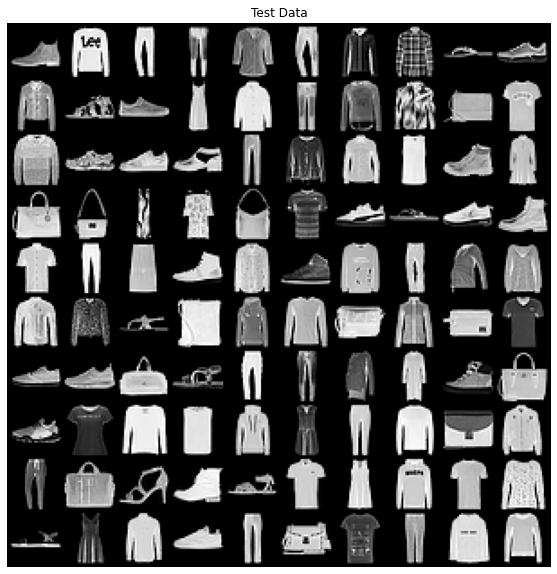

In [8]:
test_data = FashionMNIST("./data", train = False, download = True,
                          transform=transforms.ToTensor())
data_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

width = 28
height = 28
input_size = width * height

first_batch = next(iter(data_loader))
plot_images(first_batch[0], 10, 10, "Test Data")

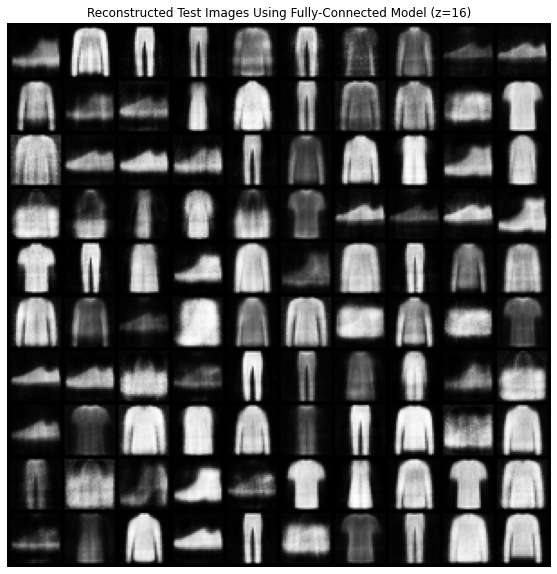

In [9]:
fc_model_16_out = fc_model_16(first_batch[0])

plot_images(fc_model_16_out, 10, 10, "Reconstructed Test Images Using Fully-Connected Model (z=16)")

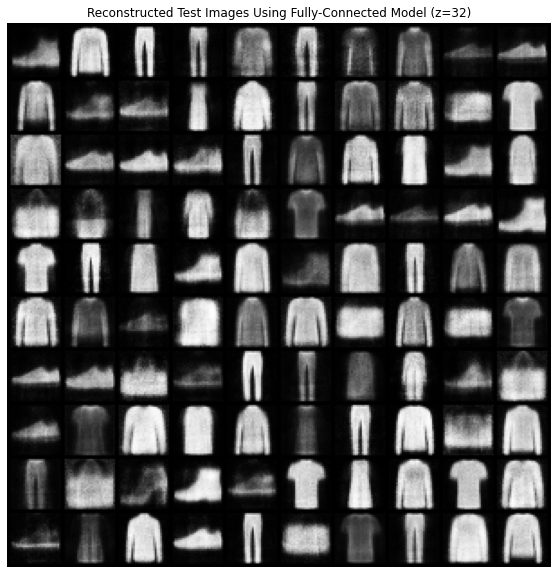

In [10]:
fc_model_32_out = fc_model_32(first_batch[0])

plot_images(fc_model_32_out, 10, 10, "Reconstructed Test Images Using Fully-Connected Model (z=32)")

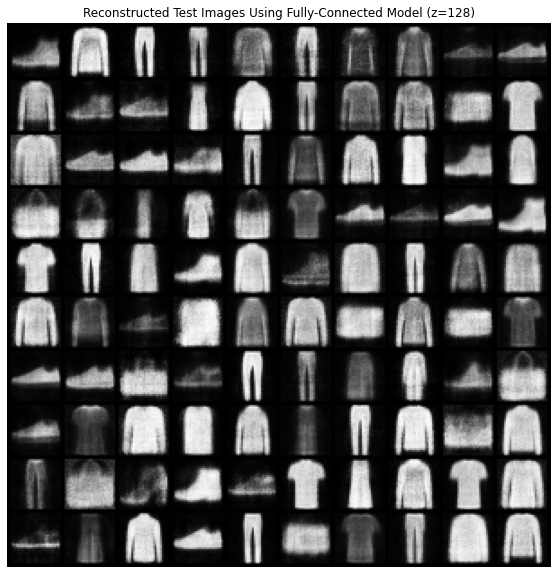

In [11]:
fc_model_128_out = fc_model_128(first_batch[0])

plot_images(fc_model_128_out, 10, 10, "Reconstructed Test Images Using Fully-Connected Model (z=128)")

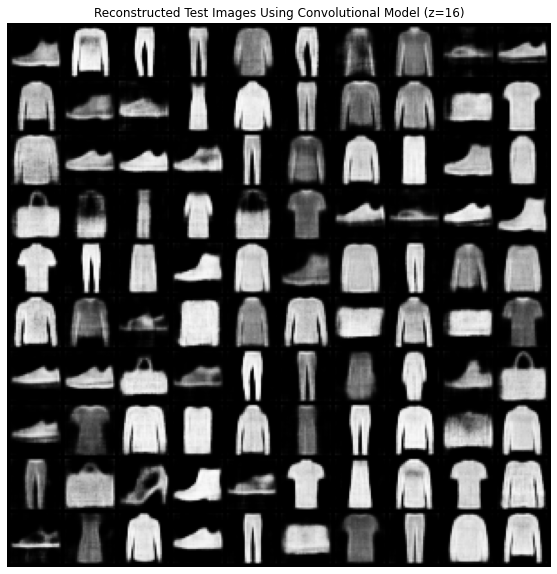

In [12]:
conv_model_16_out = conv_model_16(first_batch[0])

plot_images(conv_model_16_out, 10, 10, "Reconstructed Test Images Using Convolutional Model (z=16)")

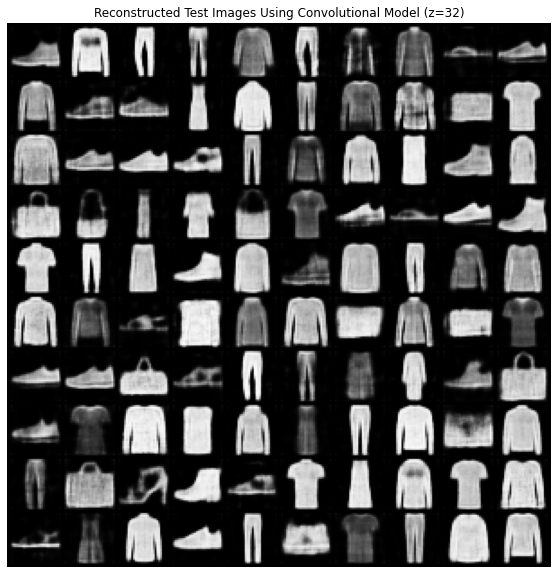

In [13]:
conv_model_32_out = conv_model_32(first_batch[0])

plot_images(conv_model_32_out, 10, 10, "Reconstructed Test Images Using Convolutional Model (z=32)")

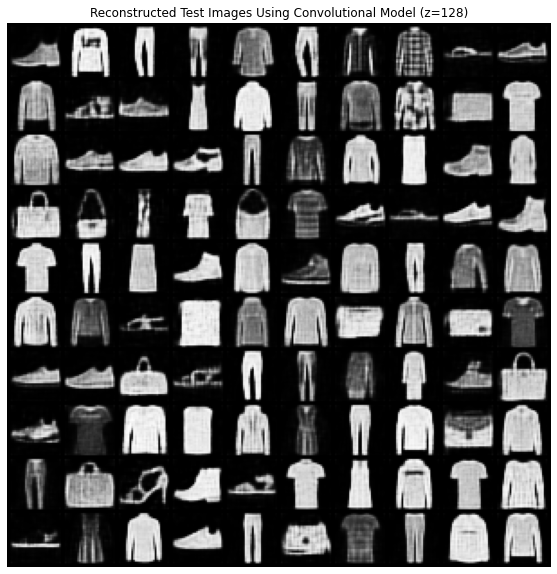

In [14]:
conv_model_128_out = conv_model_128(first_batch[0])

plot_images(conv_model_128_out, 10, 10, "Reconstructed Test Images Using Convolutional Model (z=128)")

The convolutional autoencoders appear to do a better job at reconstructing images from the test set than the fully-connected autoencoders. This may be due to the fact that the convolution operation attempts to capture local relationships in the image by looking regions of adjacent pixels specified by the kernel size whereas the fully-connected autoencoder looks at each entry of the input vector in isolation. This means that if we applied the same permutation to every single flattened array of pixel data in our training set, the fully-connected autoencoder would predict the same results. The spatial information gained from using the convolution may be what is improving performance. 

In addition, we can see that when the dimension of the latent space is increased, reconstructed images are much better. The larger the dimension of the latent space representation is, the more data we can capture, allowing us to preserve more of the original image. 

### Problem 3: Reconstructing Images from Test Set Using PCA

In [15]:
# loading entire dataset
data_loader = DataLoader(train_data, batch_size = len(train_data), shuffle = False)

trainX, trainY = next(iter(data_loader))

In [16]:
trainX = torch.reshape(trainX, (-1, 784))

In [17]:
print(trainX.shape)

torch.Size([60000, 784])


In [18]:
from sklearn.decomposition import PCA

# computing PCA on training set 
pca = PCA(n_components=784)
pca.fit(trainX)
eigenVecs = torch.Tensor(pca.components_).T

print(eigenVecs.shape)

torch.Size([784, 784])


torch.Size([100, 1, 28, 28])


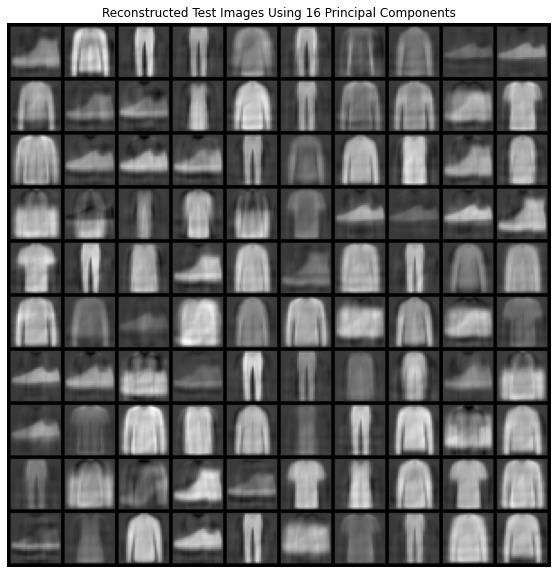

In [19]:
data_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

first_batch = next(iter(data_loader))

first_batch = first_batch[0]

print(first_batch.shape)

selected_eigenVecs = eigenVecs[:,:16]

first_batch_reshaped = torch.reshape(first_batch, (-1, 28, 28))
first_batch_reshaped = torch.reshape(first_batch_reshaped, (-1, 784)) # 100x784
latent_data = torch.matmul(first_batch_reshaped, selected_eigenVecs)

reconstructedData_16 = torch.matmul(latent_data, selected_eigenVecs.T)

reconstructedData_16 = torch.reshape(reconstructedData_16, (-1, 1, 28, 28))

plot_images(reconstructedData_16, 10, 10, "Reconstructed Test Images Using 16 Principal Components")

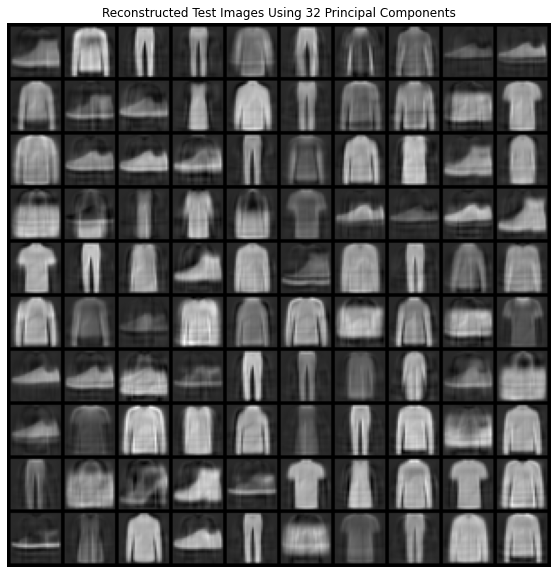

In [20]:
selected_eigenVecs = eigenVecs[:,:32]

latent_data = torch.matmul(first_batch_reshaped, selected_eigenVecs)

reconstructedData_32 = torch.matmul(latent_data, selected_eigenVecs.T)

reconstructedData_32 = torch.reshape(reconstructedData_32, (-1, 1, 28, 28))

plot_images(reconstructedData_32, 10, 10, "Reconstructed Test Images Using 32 Principal Components")

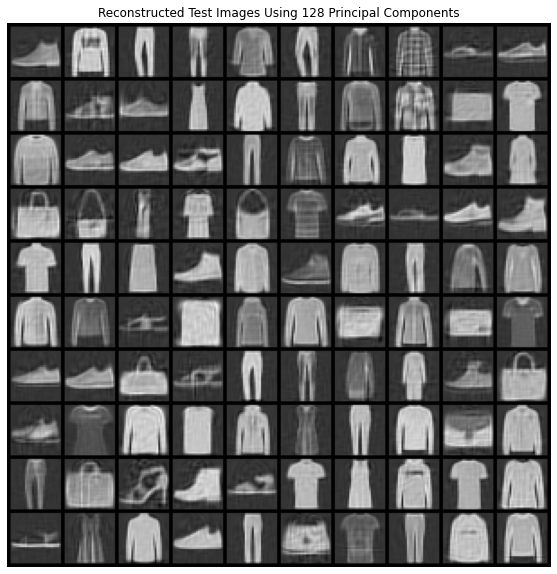

In [21]:
selected_eigenVecs = eigenVecs[:,:128]

latent_data = torch.matmul(first_batch_reshaped, selected_eigenVecs)

reconstructedData_128 = torch.matmul(latent_data, selected_eigenVecs.T)

reconstructedData_128 = torch.reshape(reconstructedData_128, (-1, 1, 28, 28))

plot_images(reconstructedData_128, 10, 10, "Reconstructed Test Images Using 128 Principal Components")

Qualitatively comparing the outputs of the autoencoders to the images reconstructed using PCA, we can see that the autoencoders are much more capable of preserving the shape and detail of the original images. From this observation we can infer that the manifold on which the data lies is a non-linear subspace, which PCA can only approximate linearly by projecting our data into a lower dimension specified by the selected principal components. The nonlinearities introduced by the activation functions in the fully-connected networks (ELU) and the convolution operations in the CNNs do a much better job of approximating the manifold.

### Problem 4: Image Interpolations

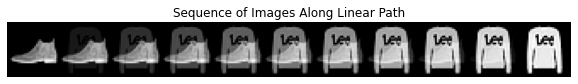

In [22]:
a = first_batch_reshaped[0]
b = first_batch_reshaped[1] # Images from two different classes

# (1-t)*a + t*b, t = [0,1]

img_seq = torch.empty(11,784)

for t in range(0,11):
    img_seq[t] = (1-(t/10))*a + (t/10)*b

img_seq = torch.reshape(img_seq, (11, 1, 28, 28))    
plot_images(img_seq, 11, 1, "Sequence of Images Along Linear Path")

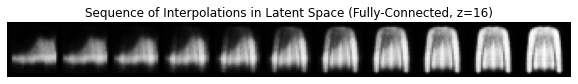

In [23]:
a = torch.reshape(a, (1,784))
b = torch.reshape(b, (1,784))


latent_rep_a = fc_model_16.encoder(a)

latent_rep_b = fc_model_16.encoder(b)

img_seq = torch.empty(11,784)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = fc_model_16.decoder(curr_latent_rep)
    
img_seq = torch.reshape(img_seq, (11, 1, 28, 28))    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Fully-Connected, z=16)")

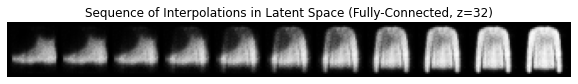

In [24]:
a = torch.reshape(a, (1,784))
b = torch.reshape(b, (1,784))


latent_rep_a = fc_model_32.encoder(a)

latent_rep_b = fc_model_32.encoder(b)

img_seq = torch.empty(11,784)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = fc_model_32.decoder(curr_latent_rep)
    
img_seq = torch.reshape(img_seq, (11, 1, 28, 28))    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Fully-Connected, z=32)")

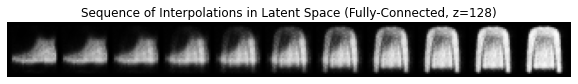

In [25]:
a = torch.reshape(a, (1,784))
b = torch.reshape(b, (1,784))


latent_rep_a = fc_model_128.encoder(a)

latent_rep_b = fc_model_128.encoder(b)

img_seq = torch.empty(11,784)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = fc_model_128.decoder(curr_latent_rep)
    
img_seq = torch.reshape(img_seq, (11, 1, 28, 28))    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Fully-Connected, z=128)")

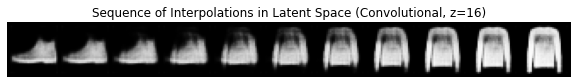

In [26]:
a = torch.reshape(a, (1,1,28,28))
b = torch.reshape(b, (1,1,28,28))


latent_rep_a = conv_model_16.encoder(a)

latent_rep_b = conv_model_16.encoder(b)

img_seq = torch.empty(11,1,28,28)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = conv_model_16.decoder(curr_latent_rep)
    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Convolutional, z=16)")

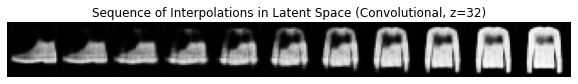

In [27]:
latent_rep_a = conv_model_32.encoder(a)

latent_rep_b = conv_model_32.encoder(b)

img_seq = torch.empty(11,1,28,28)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = conv_model_32.decoder(curr_latent_rep)
    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Convolutional, z=32)")

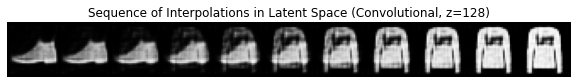

In [28]:
latent_rep_a = conv_model_128.encoder(a)

latent_rep_b = conv_model_128.encoder(b)

img_seq = torch.empty(11,1,28,28)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = conv_model_128.decoder(curr_latent_rep)
    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Convolutional, z=128)")

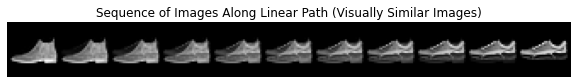

In [29]:
# Repeating for visually similar images

a = first_batch_reshaped[0]
b = first_batch_reshaped[9]

img_seq = torch.empty(11,784)

for t in range(0,11):
    img_seq[t] = (1-(t/10))*a + (t/10)*b

img_seq = torch.reshape(img_seq, (11, 1, 28, 28))    
plot_images(img_seq, 11, 1, "Sequence of Images Along Linear Path (Visually Similar Images)")

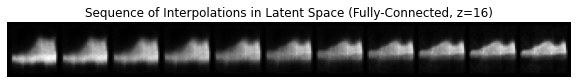

In [30]:
a = torch.reshape(a, (1,784))
b = torch.reshape(b, (1,784))


latent_rep_a = fc_model_16.encoder(a)

latent_rep_b = fc_model_16.encoder(b)

img_seq = torch.empty(11,784)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = fc_model_16.decoder(curr_latent_rep)
    
img_seq = torch.reshape(img_seq, (11, 1, 28, 28))    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Fully-Connected, z=16)")

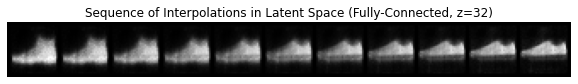

In [31]:
a = torch.reshape(a, (1,784))
b = torch.reshape(b, (1,784))


latent_rep_a = fc_model_32.encoder(a)

latent_rep_b = fc_model_32.encoder(b)

img_seq = torch.empty(11,784)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = fc_model_32.decoder(curr_latent_rep)
    
img_seq = torch.reshape(img_seq, (11, 1, 28, 28))    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Fully-Connected, z=32)")

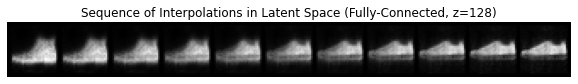

In [32]:
a = torch.reshape(a, (1,784))
b = torch.reshape(b, (1,784))


latent_rep_a = fc_model_128.encoder(a)

latent_rep_b = fc_model_128.encoder(b)

img_seq = torch.empty(11,784)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = fc_model_128.decoder(curr_latent_rep)
    
img_seq = torch.reshape(img_seq, (11, 1, 28, 28))    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Fully-Connected, z=128)")

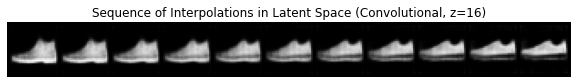

In [33]:
a = torch.reshape(a, (1,1,28,28))
b = torch.reshape(b, (1,1,28,28))


latent_rep_a = conv_model_16.encoder(a)

latent_rep_b = conv_model_16.encoder(b)

img_seq = torch.empty(11,1,28,28)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = conv_model_16.decoder(curr_latent_rep)
    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Convolutional, z=16)")

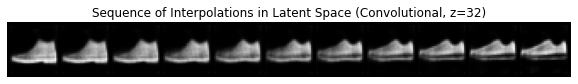

In [34]:
latent_rep_a = conv_model_32.encoder(a)

latent_rep_b = conv_model_32.encoder(b)

img_seq = torch.empty(11,1,28,28)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = conv_model_32.decoder(curr_latent_rep)
    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Convolutional, z=32)")

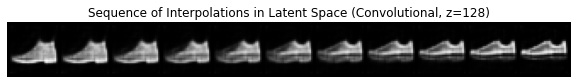

In [35]:
latent_rep_a = conv_model_128.encoder(a)

latent_rep_b = conv_model_128.encoder(b)

img_seq = torch.empty(11,1,28,28)

for t in range(0,11):
    curr_latent_rep = (1-(t/10))*latent_rep_a + (t/10)*latent_rep_b
    img_seq[t] = conv_model_128.decoder(curr_latent_rep)
    
plot_images(img_seq, 11, 1, "Sequence of Interpolations in Latent Space (Convolutional, z=128)")

When our two images are from completely separate classes, the simple linear interpolation yields several intermediate images that contain a sillhouette of one image superimposed on top of the other. These are clearly nonsensical images of objects that do not exist in the real world. 

The intermediate images appear slightly better when we interpolate in the latent space using both the fully-connected and convolutional layers. As mentioned in the previous problem, the convolutional network paired with larger latent space dimensions results in more of the original information being preserved (e.g crisper and clearer images) but while the transitions are smoother and we no longer see "ghosts" of either image during the interpolation process, the intermediate images are still not quite reasonable and can't be said to belong to either of the two classes. 

However, when we choose two images from the same class (e.g a boot and a sneaker), we can immediately see that the intermediate images in the sequence all resemble images belonging to that class, even though none of them are actual images present in the dataset. This gives us the sense that we have been able to learn some notion of a lower-dimensional manifold on which the data actually lies. 


### Problem 5: Immersions and Submersions

$f_i(z^i) = \Phi(W^i z^i + b^i)$

$Df_i(z^i) = D\Phi \cdot W^i$ (chain rule) 

In order for a layer $f_i$ to be an immersion, it must be differentiable and its jacobian $Df_i(z^i)$ must be injective (i.e it must be full rank, or its columns linearly independent). We also know that the composition of two immersions is also an immersion. If each subsequent layer of the decoder is increasing in dimension, we can simply look at the rank of $Df_i(z^i)$ at each layer and ensure that it is maximal in order to determine that the decoder is an immersion. This is also true for determining whether the encoders are submersions in the case that subsequent layers are monotonically decreasing in dimension. 

Since our activation function for the fully-connected networks (ELU) is differentiable and batch normalization is also differentiable, we only need to look at the weight matrices $(W^i)$ in the case that the dimensions are monotonically increasing/decreasing. This is the case for the encoders/decoders of all the fully-connected layer models so we are able to say definitively whether or not they are immersions/submersions. 

For the convolutional layer models however, the dimensions are not monotonically increasing/decreasing in the decoder and encoder respectively and we are therefore unable to deterimine globally whether they are immersions/submersions. This is because we are no longer looking at just the static weight matrix and need to consider $D\Phi$ as well, which will change based on the input $x$. Since $x$ is a continuous variable, the best we can do is compute the jacobian at every point in our dataset and state that empirically, the encoder/decoder appears to be an immersion if all of the jacobians are full rank. For this reason, we can't determine the property of immersions/submersions for any of the convolutional models purely by looking at the weight matrices at each layer. 

In [36]:
# Calculating rank of weight matrix at each layer

def min_max_rank(singular_values):
    minVal = min(singular_values)
    maxVal = max(singular_values)
    flag = True
    if minVal < 1e-6:
        flag = False
    return (minVal, maxVal, flag)

fc_models = [fc_model_16, fc_model_32, fc_model_128]
fc_model_names = ['Fully Connected (z=16)', 'Fully Connected (z=32)', 'Fully Connected (z=128)']
for i in range(len(fc_models)):
    fc_model = fc_models[i]
    ew1 = fc_model.elayer1.weight.data
    ew2 = fc_model.elayer2.weight.data
    ew3 = fc_model.elayer3.weight.data
    
    dw1 = fc_model.dlayer1.weight.data
    dw2 = fc_model.dlayer2.weight.data
    dw3 = fc_model.dlayer3.weight.data
    
    ews = [ew1, ew2, ew3]
    dws = [dw1, dw2, dw3]
    
    ew_flag = True
    
    for ew in ews:
        u, s, vt = np.linalg.svd(ew)
        minVal, maxVal, f = min_max_rank(s)
        if f == False:
            break
    
    ew_flag = f    
    
    for dw in dws:
        u, s, vt = np.linalg.svd(dw)
        minVal, maxVal, f = min_max_rank(s)
        if f == False:
            break
    
    dw_flag = f
    
    print('Model: '+ fc_model_names[i])
    print("Encoder is submersion: " + str(ew_flag))
    print("Decoder is immersion: " + str(dw_flag))

Model: Fully Connected (z=16)
Encoder is submersion: True
Decoder is immersion: True
Model: Fully Connected (z=32)
Encoder is submersion: True
Decoder is immersion: True
Model: Fully Connected (z=128)
Encoder is submersion: True
Decoder is immersion: True


Note: See explanations for conclusions in the previous cell

#### Fully-Connected Layer Model (z=16)
**a.** $\mathbb{R}^{784} \to \mathbb{R}^{256} \to \mathbb{R}^{128} \to \mathbb{R}^{16} \to \mathbb{R}^{128} \to \mathbb{R}^{256} \to \mathbb{R}^{784}$

**b.** The encoder is a submersion, monotonically decreasing in dimension and weight matrix is full rank

**c.** The decoder is an immersion, monotonically increasing in dimension and weight matrix is full rank


#### Fully-Connected Layer Model (z=32)
**a.** $\mathbb{R}^{784} \to \mathbb{R}^{256} \to \mathbb{R}^{128} \to \mathbb{R}^{32} \to \mathbb{R}^{128} \to \mathbb{R}^{256} \to \mathbb{R}^{784}$

**b.** The encoder is a submersion, monotonically decreasing in dimension and weight matrix is full rank

**c.** The decoder is an immersion, monotonically increasing in dimension and weight matrix is full rank

#### Fully-Connected Layer Model (z=128)
**a.** $\mathbb{R}^{784} \to \mathbb{R}^{256} \to \mathbb{R}^{128} \to \mathbb{R}^{128} \to \mathbb{R}^{256} \to \mathbb{R}^{784}$

**b.** The encoder is a submersion, monotonically decreasing in dimension and weight matrix is full rank

**c.** The decoder is an immersion, monotonically increasing in dimension and weight matrix is full rank

#### Convolutional Layer Model (z=16)
**a.** $\mathbb{R}^{784} \to \mathbb{R}^{18,432} \to \mathbb{R}^{3,200} \to \mathbb{R}^{16} \to \mathbb{R}^{3,200} \to \mathbb{R}^{18,432} \to \mathbb{R}^{784}$

**b.** Cannot determine globally from weight matrices alone (see above explanation)

**c.** Cannot determine globally from weight matrices alone (see above explanation)

#### Convolutional Layer Model (z=32)
**a.** $\mathbb{R}^{784} \to \mathbb{R}^{18,432} \to \mathbb{R}^{3,200} \to \mathbb{R}^{32} \to \mathbb{R}^{3,200} \to \mathbb{R}^{18,432} \to \mathbb{R}^{784}$

**b.** Cannot determine globally from weight matrices alone (see above explanation)

**c.** Cannot determine globally from weight matrices alone (see above explanation)

#### Convolutional Layer Model (z=128)
**a.** $\mathbb{R}^{784} \to \mathbb{R}^{18,432} \to \mathbb{R}^{3,200} \to \mathbb{R}^{128} \to \mathbb{R}^{3,200} \to \mathbb{R}^{18,432} \to \mathbb{R}^{784}$

**b.** Cannot determine globally from weight matrices alone (see above explanation)

**c.** Cannot determine globally from weight matrices alone (see above explanation)

### Problem 6: Jacobian Matrix and SVD

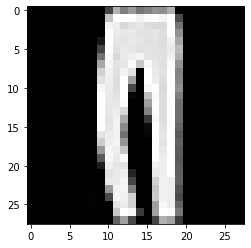

In [37]:
import matplotlib.pyplot as plt 

data_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

first_batch = next(iter(data_loader))

# a = first_batch[0][0]
a = first_batch[0][2]

a = torch.reshape(a, (28,28))
plt.imshow(a, cmap='gray')

a = torch.reshape(a, (1,784))

In [38]:
def decoder_jacobian(model, img, out_size):
    latent_rep = model.encoder(img)
    jac = torch.autograd.functional.jacobian(model.decoder, (latent_rep))
    jac = torch.reshape(jac, (784, out_size))
    return jac

jac_fc_16 = decoder_jacobian(fc_model_16, a, 16)
jac_fc_32 = decoder_jacobian(fc_model_32, a, 32)
jac_fc_128 = decoder_jacobian(fc_model_128, a, 128)

a = torch.reshape(a, (1,1,28,28))

jac_conv_16 = decoder_jacobian(conv_model_16, a, 16)
jac_conv_32 = decoder_jacobian(conv_model_32, a, 32)
jac_conv_128 = decoder_jacobian(conv_model_128, a, 128)

In [39]:
jacobians = [jac_fc_16, jac_fc_32, jac_fc_128, jac_conv_16, jac_conv_32, jac_conv_128]
models = ['Fully Connected (z=16)', 'Fully Connected (z=32)', 'Fully Connected (z=128)',
          'Convolutional (z=16)', 'Convolutional (z=32)', 'Convolutional (z=128)' ]


for i in range (len(models)):
    u, s, vt = np.linalg.svd(jacobians[i])
    minVal, maxVal, f = min_max_rank(s)
    print('Model: '+ models[i])
    print('Min Val: ' + str(minVal) + '\tMax Val: ' + str(maxVal) + '\tFull Rank:' + str(f))

Model: Fully Connected (z=16)
Min Val: 0.9449602	Max Val: 9.036128	Full Rank:True
Model: Fully Connected (z=32)
Min Val: 0.2592507	Max Val: 6.96647	Full Rank:True
Model: Fully Connected (z=128)
Min Val: 1.7706051e-06	Max Val: 5.5278106	Full Rank:True
Model: Convolutional (z=16)
Min Val: 0.8708527	Max Val: 6.6614885	Full Rank:True
Model: Convolutional (z=32)
Min Val: 0.42315137	Max Val: 5.414882	Full Rank:True
Model: Convolutional (z=128)
Min Val: 0.15715791	Max Val: 7.099483	Full Rank:True


### Problem 7: Tangent Vectors

torch.Size([16, 1, 28, 28])


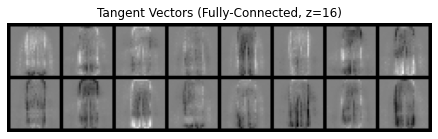

In [40]:
tangent_vecs = jac_fc_16.T
tangent_vecs = torch.reshape(tangent_vecs, (16, 1, 28, 28))

print(tangent_vecs.shape)

plot_images(tangent_vecs, 8, 2, 'Tangent Vectors (Fully-Connected, z=16)')

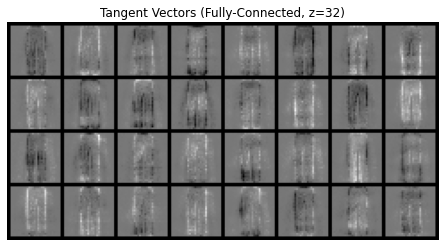

In [41]:
tangent_vecs = jac_fc_32.T
tangent_vecs = torch.reshape(tangent_vecs, (32, 1, 28, 28))

plot_images(tangent_vecs, 8, 4, 'Tangent Vectors (Fully-Connected, z=32)')

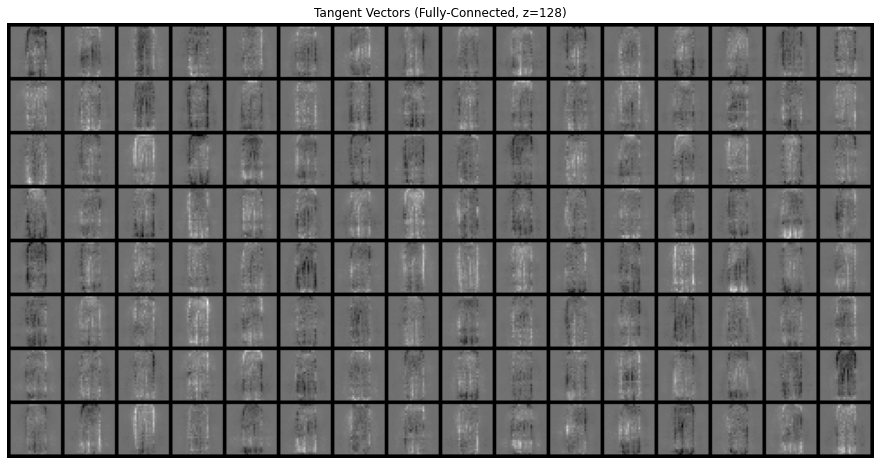

In [42]:
tangent_vecs = jac_fc_128.T
tangent_vecs = torch.reshape(tangent_vecs, (128, 1, 28, 28))

plot_images(tangent_vecs, 16, 8, 'Tangent Vectors (Fully-Connected, z=128)')

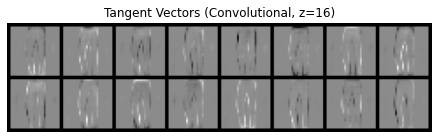

In [43]:
tangent_vecs = jac_conv_16.T
tangent_vecs = torch.reshape(tangent_vecs, (16, 1, 28, 28))

plot_images(tangent_vecs, 8, 2, 'Tangent Vectors (Convolutional, z=16)')

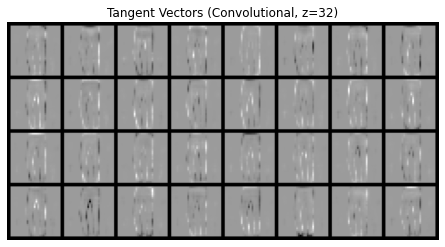

In [44]:
tangent_vecs = jac_conv_32.T
tangent_vecs = torch.reshape(tangent_vecs, (32, 1, 28, 28))

plot_images(tangent_vecs, 8, 4, 'Tangent Vectors (Convolutional, z=32)')

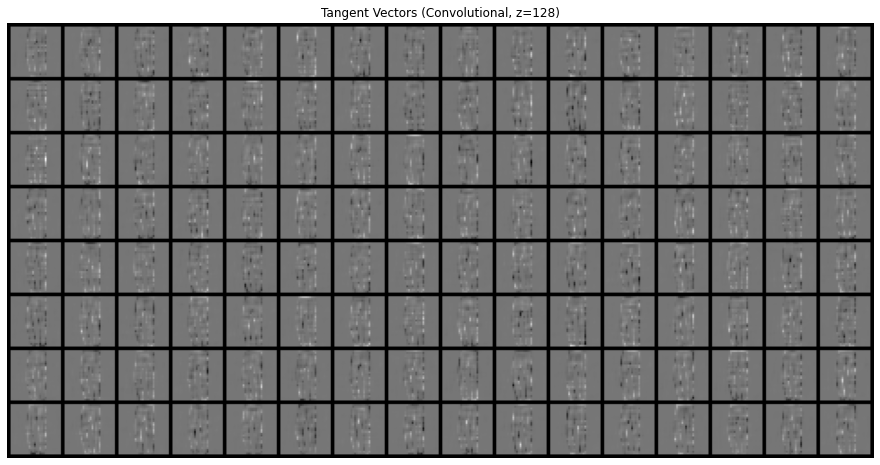

In [45]:
tangent_vecs = jac_conv_128.T
tangent_vecs = torch.reshape(tangent_vecs, (128, 1, 28, 28))

plot_images(tangent_vecs, 16, 8, 'Tangent Vectors (Convolutional, z=128)')

Each of the tangent vectors appears to be capturing some variation in different parts of the image. In the above example, we are selecting an image of a pair of pants from the test set so the tangent vectors seem to be capturing variation that might occur in that image (i.e different patterns, shapes, and orientations). Each tangent vectors seems to be highlighting variation in different regions of the image (i.e the waistband, legs, and leg openings of the pants).  

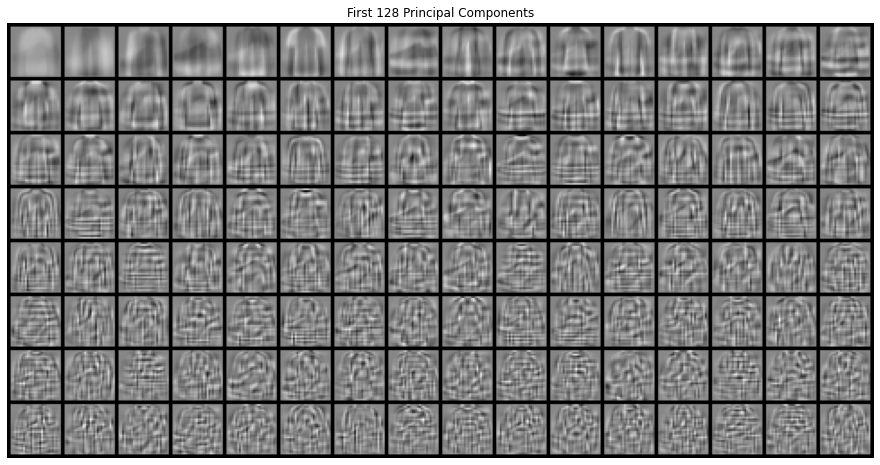

In [46]:
# Plotting eigenvectors

selected_eigenVecs = eigenVecs[:,:128]
selected_eigenVecs = selected_eigenVecs.T
selected_eigenVecs = torch.reshape(selected_eigenVecs, (128, 1, 28, 28))

plot_images(selected_eigenVecs, 16, 8, "First 128 Principal Components")

Text(0.5, 1.0, 'Scree Plot')

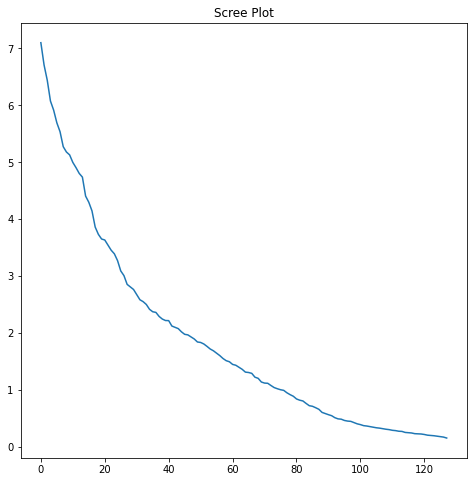

In [47]:
eigenVals = s

eigenValSum = eigenVals.real.sum()

cumulativeVars = []

i = 1
currentSum = 0
for eigenVal in eigenVals: # Trying to achieve 90% of data variance
    if (currentSum + eigenVal.real)/eigenValSum > 0.9:
        cumulativeVars.append(currentSum/eigenValSum)
        break
    currentSum += eigenVal.real
    cumulativeVars.append(currentSum/eigenValSum)
    i += 1

    
x = np.linspace(0, eigenVals.shape[0] - 1, num=eigenVals.shape[0])

from matplotlib.pyplot import figure

figure(figsize=(8, 8))

plt.plot(x, eigenVals.real) # plotting eigenvalues
plt.title('Scree Plot') # magnitude = variance along corresponding eigenvector

Text(0.5, 1.0, 'Accumulated Data Variance')

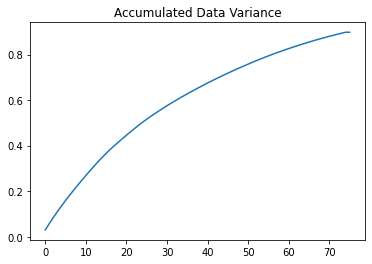

In [48]:
x = np.linspace(0, i-1, i)

plt.plot(x, cumulativeVars) # plotting accumulated data variance
plt.title('Accumulated Data Variance')

It is difficult to qualatively make sense of the plots of the principal components, but we can see that the first several components appear to roughly correspond to the MNIST Fashion dataset classes. We know that each component is capturing variation along different axes in a linear subspace and each of these tangent vectors can be thought of as basis vectors for this new space. Above, the scree plot of the eigenvalues (each of which represents the amount of variation captured by its corresponding component), we see a sharply decreasing trend, meaning that the first several principal components capture a majority of the data while components at the tail give us marginal returns. This explains why the components become increasingly noisy.

### Problem 8: Rotations/Translations in Tangent Space

We can apply a small rotation/translation to a base image and approximate the derivative with respect to $x,y$ or $\theta$ using finite difference: $\frac{dc}{dt} = \frac{c(0+\epsilon) - c(0)}{\epsilon}$ where $c(0)$ is the original image. Next, we can check if $\frac{dc}{dt}$ is in the column space of the Jacobian. We can do this by using the method of least squares, which will give us the orthogonal projection onto the tangent space via the solution to the equation: $J \hat x = \frac{dc}{dt}$ where $J$ is the Jacobian and $\hat x$ is a set of coeffieicents corresponding to each of the tangent vectors. We can then compute the dot product between $J\hat x$ and $\frac{dc}{dt}$ to determine the angle between the two vectors. The smaller that angle is, the better our learned manifold encompasses rotations and translations of our training data.

In [51]:
from scipy import ndimage
import math

def unit_vector(v):
    return v / np.linalg.norm(v)

def compute_angle(v1, v2):
    v1_unit = unit_vector(v1)
    v2_unit = unit_vector(v2)
    t = np.arccos(np.clip(torch.matmul(v1_unit.T, v2_unit), -1.0, 1.0))
    return math.degrees(t)


base_images = []

model_outputs = [fc_model_16_out, fc_model_32_out, fc_model_128_out, conv_model_16_out, conv_model_32_out, conv_model_128_out]

# passing base image through each model to get decoded output
for model_out in model_outputs:
    curr_img = model_out[2] # same image used to calculate Jacobian
    curr_img = torch.reshape(curr_img, (28,28))
    curr_img = curr_img.detach().numpy()
    base_images.append(curr_img)

angle_epsilon = 1 # 1 degree
x_epsilon = 1 # 1 pixel
y_epsilon = 1 # 1 pixel

epsilons = [angle_epsilon, x_epsilon, y_epsilon]

my_vars = ["Rotation", "X Translation", "Y Translation"]

for i in range(len(jacobians)):
    A = jacobians[i]
    print("Model: " + str(models[i]))
    
    base_image = base_images[i] # same image used to calculate Jacobian
    # applying small rotations/translations
    rotated_image = ndimage.rotate(base_image, angle_epsilon, reshape=False)
    translated_x_image = ndimage.shift(base_image, [0, x_epsilon])
    translated_y_image = ndimage.shift(base_image, [y_epsilon,0])

    rotated_image = torch.from_numpy(rotated_image)
    rotated_image = torch.reshape(rotated_image, (784,1))

    translated_x_image = torch.from_numpy(translated_x_image)
    translated_x_image = torch.reshape(translated_x_image, (784,1))

    translated_y_image = torch.from_numpy(translated_y_image)
    translated_y_image = torch.reshape(translated_y_image, (784,1))

    base_image = np.reshape(base_image, (784,1))

    transformed_images = [rotated_image, translated_x_image, translated_y_image]
    for j in range(len(transformed_images)):
        c = (transformed_images[j] - base_image)/epsilons[j] # finite difference approximation
        coeffs = np.linalg.lstsq(A, c, rcond=None)[0] # least squares minimization to find projection
        coeffs = torch.from_numpy(coeffs)
        v = torch.matmul(A, coeffs)
        angle = compute_angle(v, c) # compute angle using dot product
        print(my_vars[j] + ": " + str(angle))
    print('\n')

Model: Fully Connected (z=16)
Rotation: 59.93695902361289
X Translation: 42.993698070344955
Y Translation: 48.321583717318816


Model: Fully Connected (z=32)
Rotation: 50.25516246002523
X Translation: 35.34051550157527
Y Translation: 34.24940985713866


Model: Fully Connected (z=128)
Rotation: 34.059257390645506
X Translation: 27.278348035494396
Y Translation: 27.933363176898617


Model: Convolutional (z=16)
Rotation: 49.01422978595522
X Translation: 42.91672866858808
Y Translation: 33.19424125302007


Model: Convolutional (z=32)
Rotation: 40.9516627538079
X Translation: 37.94665955675826
Y Translation: 30.509652475219482


Model: Convolutional (z=128)
Rotation: 22.459892047765933
X Translation: 21.07479798597905
Y Translation: 15.744946952071516




As we can see, the angle between the two vectors decreases as the dimension of the latent space increases, and gets even smaller when using the convolutional layer model. However even with the most powerful convolutional model, the angle between the two vectors is not close to zero, which leads us to believe that our learned manifolds for each of the models does not adequately encompass rotations and translations. This makes sense due to the uniform nature of the dataset since all images seem to be almost perfectly aligned along the axes. Augmenting the dataset with images that have some random rotation and translation applied to them could alleviate the rigidity that we see with these autoencoder models.  

In [52]:
components = [eigenVecs[:,:16], eigenVecs[:,:32], eigenVecs[:,:128]]
n_components = ['16 Components', '32 Components', '128 Components']

# same base image reconstructed using different number of principal components
base_images = [reconstructedData_16[2][0], reconstructedData_32[2][0], reconstructedData_128[2][0]]

for i in range(len(components)):
    A = components[i]
    base_image = base_images[i]
    
    rotated_image = ndimage.rotate(base_image, angle_epsilon, reshape=False)
    translated_x_image = ndimage.shift(base_image, [0, x_epsilon])
    translated_y_image = ndimage.shift(base_image, [y_epsilon,0])

    rotated_image = torch.from_numpy(rotated_image)
    rotated_image = torch.reshape(rotated_image, (784,1))

    translated_x_image = torch.from_numpy(translated_x_image)
    translated_x_image = torch.reshape(translated_x_image, (784,1))

    translated_y_image = torch.from_numpy(translated_y_image)
    translated_y_image = torch.reshape(translated_y_image, (784,1))

    base_image = np.reshape(base_image, (784,1))
    
    transformed_images = [rotated_image, translated_x_image, translated_y_image]
    
    print("Model: " + str(n_components[i]))
    for j in range(len(transformed_images)):
        c = (transformed_images[j] - base_image)/epsilons[j] # finite difference approximation
        coeffs = np.linalg.lstsq(A, c, rcond=None)[0]
        coeffs = torch.from_numpy(coeffs)
        v = torch.matmul(A, coeffs)
        angle = compute_angle(v, c) # compute angle using dot product
        print(my_vars[j] + ": " + str(angle))
    print('\n')

Model: 16 Components
Rotation: 75.88310798070735
X Translation: 58.38025645892944
Y Translation: 59.25618040865938


Model: 32 Components
Rotation: 62.07804574349347
X Translation: 28.453898723734458
Y Translation: 41.91193612469292


Model: 128 Components
Rotation: 43.359307851331984
X Translation: 12.412140778638161
Y Translation: 20.97746437521178




Repeating the experiment with our principal components, we can see that the results are not too bad, but slightly worse than when using the autoencoders. This makes sense because we can only linearly approximate our data manifold using PCA, meaning we are more restricted and will inevitably capture/encode less information. 